In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [7]:
# Load the datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")
# Convert dates to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
# Merge datasets for EDA
merged = transactions.merge(products, on='ProductID', how='left')
final_merged_df = merged.merge(customers, on='CustomerID', how='left')
final_merged_df=final_merged_df.drop(columns=['Price_y'])


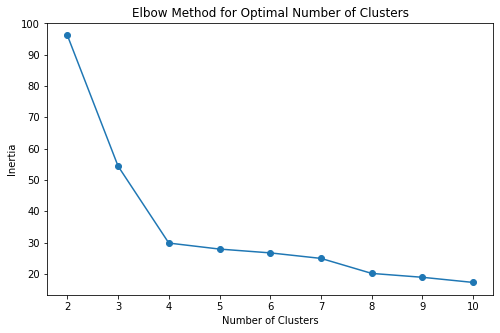

In [8]:

df = final_merged_df

# Feature Engineering
# 1. Recency (days since last purchase)
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
last_purchase = df.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_purchase.columns = ['CustomerID', 'LastPurchaseDate']
last_purchase['Recency'] = (datetime.now() - last_purchase['LastPurchaseDate']).dt.days

# 2. Frequency (number of transactions)
frequency = df.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

# 3. Monetary (total spending)
monetary = df.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']

# 4. Average Purchase Value
average_purchase_value = df.groupby('CustomerID')['TotalValue'].mean().reset_index()
average_purchase_value.columns = ['CustomerID', 'AveragePurchaseValue']

# 5. Preferred Product Category
preferred_category = df.groupby(['CustomerID', 'Category'])['Quantity'].sum().reset_index()
preferred_category = preferred_category.loc[preferred_category.groupby('CustomerID')['Quantity'].idxmax()]
preferred_category = preferred_category[['CustomerID', 'Category']]
preferred_category.columns = ['CustomerID', 'PreferredCategory']

# Merge all features into one DataFrame
customer_features = pd.merge(last_purchase[['CustomerID', 'Recency']], frequency, on='CustomerID')
customer_features = pd.merge(customer_features, monetary, on='CustomerID')
customer_features = pd.merge(customer_features, average_purchase_value, on='CustomerID')
customer_features = pd.merge(customer_features, preferred_category, on='CustomerID')

# Encode categorical variable (PreferredCategory)
customer_features = pd.get_dummies(customer_features, columns=['PreferredCategory'], drop_first=True)

# Normalize features
scaler = MinMaxScaler()
customer_features_scaled = scaler.fit_transform(customer_features.drop('CustomerID', axis=1))

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()



Davies-Bouldin Index: 0.6772235868563604
Silhouette Score: 0.5636674608484907


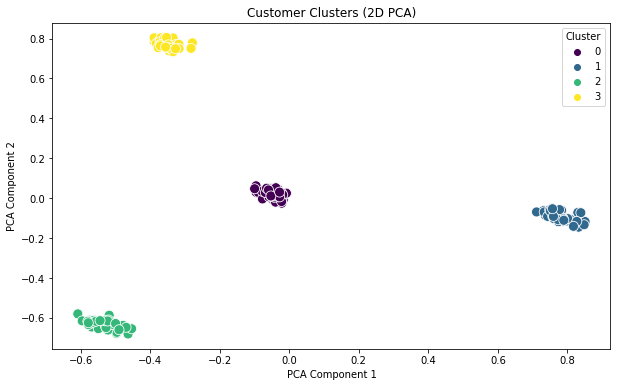

In [10]:
# Choose the optimal number of clusters
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)

# Calculate clustering metrics
db_index = davies_bouldin_score(customer_features_scaled, customer_features['Cluster'])
silhouette_avg = silhouette_score(customer_features_scaled, customer_features['Cluster'])

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

# Visualize clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
customer_features_pca = pca.fit_transform(customer_features_scaled)
customer_features['PCA1'] = customer_features_pca[:, 0]
customer_features['PCA2'] = customer_features_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_features, palette='viridis', s=100)
plt.title('Customer Clusters (2D PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.savefig('customer_clusters_pca.png', format='png')
plt.show()

# Save clustering results
customer_features.to_csv('Pratyush_Lal_clustering.csv', index=False)

In [1]:
!pip install reportlab

   ---------------------------------------- 1.9/1.9 MB 138.7 kB/s eta 0:00:00
   -------------------------------------- 199.4/199.4 kB 130.2 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


OSError: Cannot open resource "customer_clusters_pca.png"